In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from matplotlib import pyplot as plt
import seaborn as sns
from pypinyin import pinyin, lazy_pinyin, Style
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline

In [3]:
import xgboost as xgb
import lightgbm as lgb

import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.


In [4]:
ds1 = pd.read_excel('./智能投顾详细指标数据-给算法.xlsx', sheet_name='2018-9')
ds2 = pd.read_excel('./智能投顾详细指标数据-给算法.xlsx', sheet_name='2018-11-a')
ds3 = pd.read_excel('./智能投顾详细指标数据-给算法.xlsx', sheet_name='2018-11-b')

# Data preparation
* convert '落地性评分' in ds1 to categorical
* remove '拿地时间' in ds2 & ds3
* add '上会时间'
* drop '板块发展趋势'
* recover some qulitaive ranking to quantitative score

In [5]:
ds1['落地性评分'] = '不突破现有设计指标'
ds2.drop('拿地时间', axis=1, inplace=True)
ds3.drop('拿地时间', axis=1, inplace=True)

In [6]:
#ds1['上会时间'] = pd.to_datetime('2018-09-01')
#ds2['上会时间'] = pd.to_datetime('2018-11-01')
#ds3['上会时间'] = pd.to_datetime('2018-11-15')
ds1['上会时间'] = '2018-09-01'
ds2['上会时间'] = '2018-11-01'
ds3['上会时间'] = '2018-11-15'

raw_data = pd.concat([ds1, ds2, ds3])#默认纵向拼接，axis=1为横向拼接
raw_data.index = range(len(raw_data))
#raw_data.drop('板块发展趋势', axis=1, inplace=True)

In [7]:
# 板块属性
def region_rank2score(rank, city_energy=None):
    if rank.startswith('T') or rank.startswith('U'):
        return 100
    
    d12 = {'C1': 80, 'C2': 90, 'O1': 70, 'O2': 70}
    d34 = {'C1': 60, 'C2': 70, 'O1': 50, 'O2': 50}
    
    if city_energy in ['一线', '传统强二线', '新晋二线', '纯行政二线']:
        return d12.get(rank, np.NaN)
    else:
        return d34.get(rank, np.NaN)

raw_data['板块属性'] = raw_data.apply(lambda row: region_rank2score(row['板块属性'], row['城市能级']), axis=1)

# 板块发展趋势
def region_tendency2score(rank):
    if '降' in rank:
        return 70
    else:
        return 100
    
raw_data['板块发展趋势'] = raw_data['板块发展趋势'].map(region_tendency2score)

In [8]:
city_energy_rank2score = {
    '一线'       : 100,
    '传统强二线' : 100,
    '新晋二线'   : 90,
    '纯行政二线' : 80,
    '强三线'     : 60,
    '普通三线'   : 40,  
    '其他三线'   : 20,
}
#raw_data['城市能级'] = raw_data['城市能级'].map(lambda k: city_energy_rank2score[k])
raw_data['城市能级'] = raw_data['城市能级'].map(city_energy_rank2score)

market_price_rank2score = {
    '低于市场价'       : 100,
    '一二线增幅≤10%'  : 90,
    '三四线增幅≤5%'   : 90,
    '一二线增幅10-15%' : 80,
    '三四线增幅5-10%'  : 80,
    '一二线增幅15-20%' : 70,
    '三四线增幅10-15%' : 70,
    '一二线增幅20-30%' : 60,
    '三四线增幅15-25%' : 60,
    '一二线增幅30-40%' : 50,
    '三四线增幅25-35%' : 50,
    '一二线增幅＞40%'  : 20,
    '三四线增幅＞35%'  : 20,
}
raw_data['市场定价评分'] = raw_data['市场定价评分'].map(lambda k: market_price_rank2score.get(k, k))
#raw_data['市场定价评分'] = raw_data['市场定价评分'].map(market_price_rank2score)

price_cap_rank2score = {
    '无限价/有政府认可突破手段' : 100,
    '一二线突破限价5%以内'      : 90,
    '三四线突破限价10%以内'     : 90,
    '一二线突破限价5-10%'       : 70,
    '三四线突破限价10-20%'      : 70,
    '一二线突破限价10-20%'      : 50,
    '三四线突破限价20-30%'      : 50,
    '一二线突破限价20-30%'      : 30,
    '三四线突破限价30-40%'      : 30,
    '一二线突破限价>30%'       : 20,
    '三四线突破限价>40%'       : 20
}
raw_data['限价评分'] = raw_data['限价评分'].map(lambda k: price_cap_rank2score.get(k, k))
#raw_data['限价评分'] = raw_data['限价评分'].map(price_cap_rank2score)

sales_rank2score = {
    '增幅20%以下': 100,
    '增幅20-40%':  80,
    '增幅40%以上': 60,
}
raw_data['销量评分'] = raw_data['销量评分'].map(lambda k: sales_rank2score.get(k, k))

outcome2score = {
    '参拍': 1, 
    '通过': 0,
    '否决': -1,
}
raw_data['结果'] = raw_data['结果'].map(outcome2score)

Transform raw_data to learning_data
· mapping Chinese to English
· One-hot encoding for categorical variable 

In [9]:
#raw_data['市场时机'].value_counts()
#raw_data['城市'].value_counts()
#raw_data['板块属性'].value_counts()
#raw_data['板块发展趋势'].value_counts()
#raw_data['市场定价评分'].value_counts()
#raw_data['销量评分'].value_counts()

raw_data.dtypes

上会项目名称               int64
城市                  object
区域公司                object
获取方式                object
销售物业/股东方毛利率        float64
销售物业/股东方净利率        float64
销售物业/股东方IRR        float64
货地比                float64
销售物业开盘周期             int64
销售物业经营性现金流平衡周期       int64
当/次年累计销售比例         float64
次年/第三年利润累计结算比例     float64
保证金比例              float64
土地款支付节奏              int64
风险扣分               float64
2017年BSC           float64
2018年1-7月供货        float64
2018年1-7月签约        float64
2018年1-7月回款        float64
启动会奖惩\n（至18年8月）      int64
开盘靠谱度\n（至18年8月）      int64
土储去化情况             float64
城市能级                 int64
市场时机                object
板块属性                 int64
板块发展趋势               int64
市场定价评分             float64
限价评分               float64
销量评分                 int64
落地性评分               object
结果                   int64
计算得分参考             float64
上会时间                object
dtype: object

In [10]:
learning_data = raw_data.copy()
learning_data.drop('上会项目名称', axis=1, inplace=True)

columns_encodins = {
        '上会项目名称': 'ProjectID',
        '城市': 'City',
        '区域公司': 'SubCompany',
        '获取方式': 'AcquType',
        '销售物业/股东方毛利率': 'GrossProfitRate',
        '销售物业/股东方净利率': 'NetProfitRate',
        '销售物业/股东方IRR': 'IRR',
        '货地比': 'HuoDeBi',
        '销售物业开盘周期': 'PeriodToOpening',
        '销售物业经营性现金流平衡周期': 'PeriodOfCashFlowBalance',
        '当/次年累计销售比例': 'FirstCumulSalesRatio',
        '次年/第三年利润累计结算比例': 'SecondCumulSalesRatio',
        '保证金比例': 'CollateralRatio',
        '土地款支付节奏': 'TermOfLandPayment',
        '风险扣分': 'OpRisk',
        '2017年BSC': 'BSC',
        '2018年1-7月供货': 'Supply',
        '2018年1-7月签约': 'Signing',
        '2018年1-7月回款': 'MoneyBack',
        '启动会奖惩\n（至18年8月）': 'QiDongHuiJiangCheng',
        '开盘靠谱度\n（至18年8月）': 'KaiPanKaoPuDu',
        '土储去化情况': 'TuChuQuHua',
        '城市能级': 'CityEnergy',
        '市场时机': 'MarketTiming',
        '板块属性': 'RegionRankScore',
        '板块发展趋势': 'RegionTendency',
        '市场定价评分': 'MarketPricingScore',
        '限价评分': 'PriceCapScore',
        '销量评分': 'SalesScore',
        '落地性评分': 'LuoDiXing',
        '结果': 'Outcome',
        '计算得分参考': 'RefScore',
        '上会时间': 'VotingTime'}

learning_data.columns = [columns_encodins[col] for col in learning_data.columns]

In [11]:
def encode_GB_categorical(arr, rep=None):
    # encoding Chinese categorical to unqiue initials
    res = {}
    for x in arr:
        if rep:
            initials = ''.join([s[0].capitalize() for s in lazy_pinyin(x.replace(rep, ''))])
        else:
            initials = ''.join([s[0].capitalize() for s in lazy_pinyin(x)])
        
        initials = initials[:4] # maximal 4 Chars
        if initials not in res:
            res[initials] = set()
        res[initials].add(x)
        #Sprint(x, initials, res[initials])
    #return res    
    res2 = {}
    for k, vs in res.items():
        if len(vs) == 1:
            res2[vs.pop()] = k
        else:
            for i, v in enumerate(vs):
                res2[v] = '%s%d' % (k, i)
    
    res3 = { v:k for k, v in res2.items()}
        
    return res2, res3

In [12]:
city_encodings, city_decodings = encode_GB_categorical(learning_data.City)
subcompany_encodings, subcompany_decodings = encode_GB_categorical(learning_data.SubCompany, '区域')
acquisition_type_encodings, acquisition_type_decodings = encode_GB_categorical(learning_data.AcquType)
market_timing_encodings, market_timing_decodings = encode_GB_categorical(learning_data.MarketTiming)
luo_di_xing_encodings, luo_di_xing_decodings = encode_GB_categorical(learning_data.LuoDiXing)

In [13]:
# transform_learning_data
learning_data.City = learning_data.City.map(lambda x: city_encodings[x])
learning_data.SubCompany = learning_data.SubCompany.map(lambda x: subcompany_encodings[x])
learning_data.AcquType = learning_data.AcquType.map(lambda x: acquisition_type_encodings[x])
learning_data.MarketTiming = learning_data.MarketTiming.map(lambda x: market_timing_encodings[x])
learning_data.LuoDiXing = learning_data.LuoDiXing.map(lambda x: luo_di_xing_encodings[x])

# Descriptive Statistics

In [14]:
learning_data.head()

,City,SubCompany,AcquType,GrossProfitRate,NetProfitRate,IRR,HuoDeBi,PeriodToOpening,PeriodOfCashFlowBalance,FirstCumulSalesRatio,...,MarketTiming,RegionRankScore,RegionTendency,MarketPricingScore,PriceCapScore,SalesScore,LuoDiXing,Outcome,RefScore,VotingTime
0,QD,QD,ZPG,0.214200,0.120300,0.285400,2.63,9,15,0.931,...,L,100,100,90.0,100.0,100,BTPX,0,84.669933,2018-09-01
1,QD,QD,ZPG,0.214500,0.120000,0.237000,3.00,11,18,0.700,...,L,90,100,90.0,100.0,100,BTPX,0,82.586879,2018-09-01
2,JZ,QD,SBG,0.286400,0.140100,0.382900,3.21,4,17,0.765,...,L,100,100,80.0,90.0,100,BTPX,1,80.853072,2018-09-01
3,GZ1,GZ0,SBG,0.237406,0.101753,0.362042,3.25,6,16,0.640,...,L,50,100,80.0,90.0,100,BTPX,1,80.622704,2018-09-01
4,GZ1,GZ0,SBG,0.269580,0.100875,0.402111,3.57,6,16,0.613,...,L,50,100,80.0,90.0,100,BTPX,1,81.484362,2018-09-01


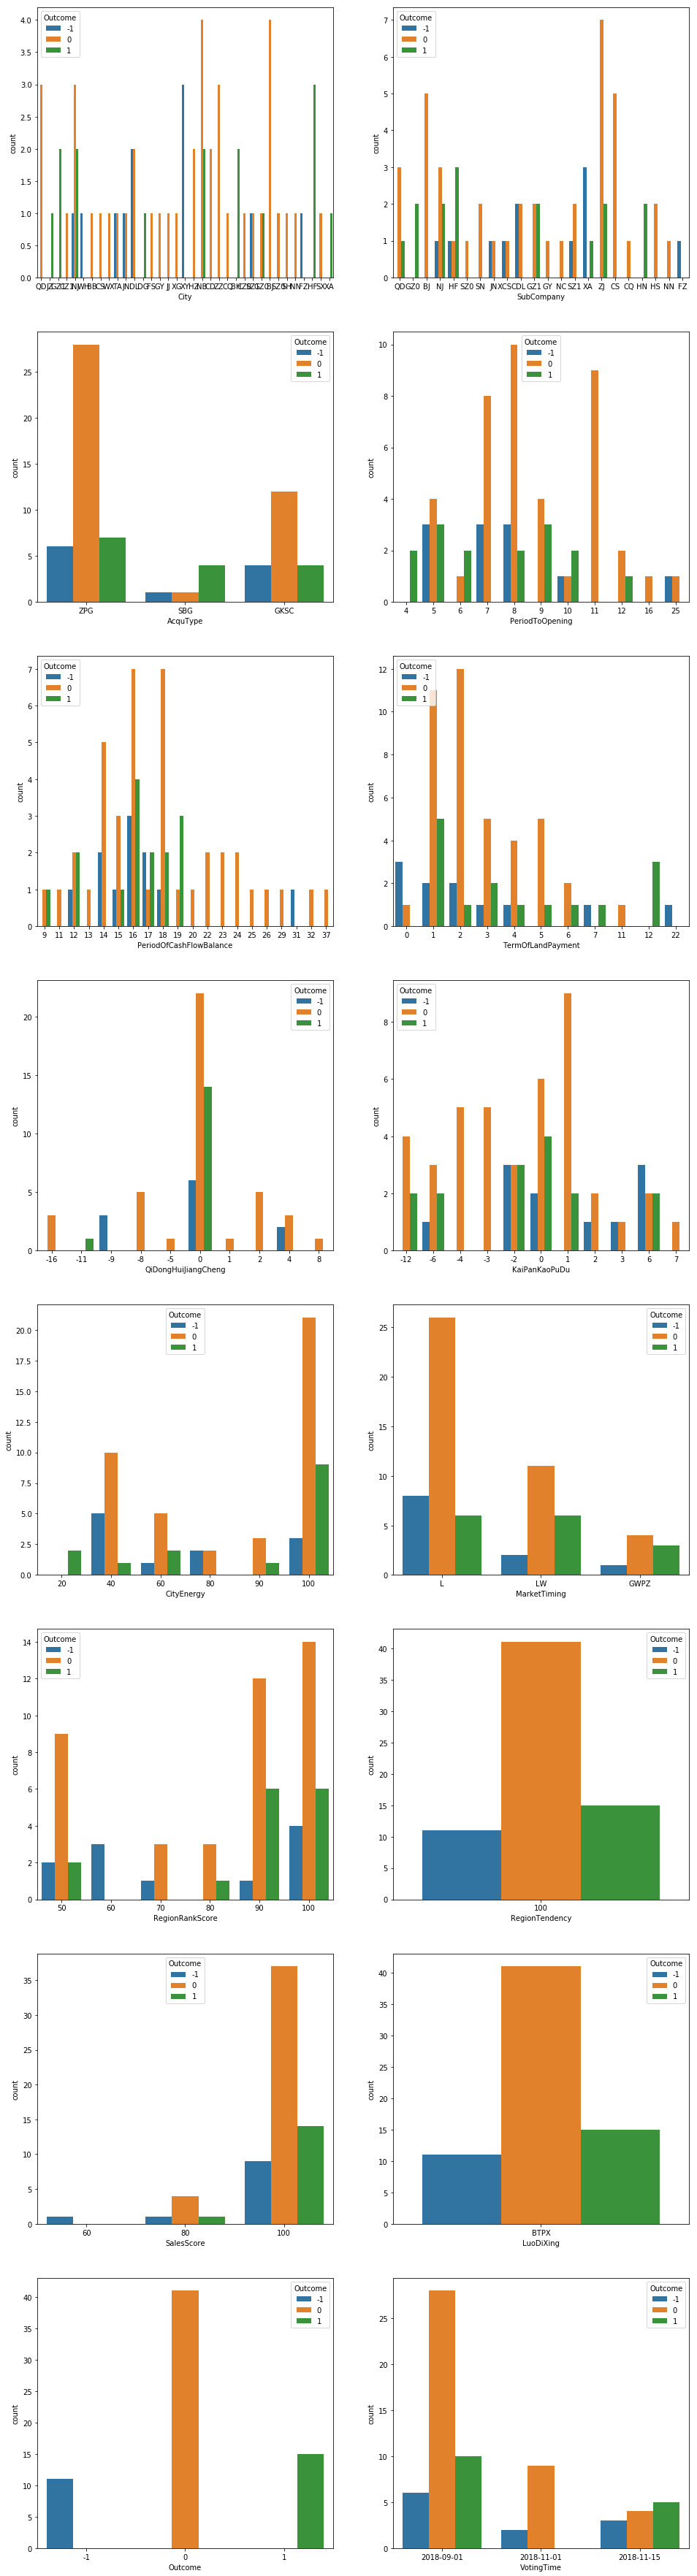

In [15]:
discrete_cols = learning_data.columns[learning_data.dtypes != np.float64]
ncols = 2
nrows = (len(discrete_cols) + 1) // ncols 
fig, ax = plt.subplots(nrows,ncols,figsize=(16, 64))

for ix in range(nrows):
    for iy in range(ncols):
        i = ix*ncols+iy
        if (i < len(discrete_cols)):
            col_name = discrete_cols[i]
            #data = raw_data[col_name].value_counts()
            #ax[ix][iy].bar(data.index, data.values))
            #ax[ix][iy].set_title(''.join(map(lambda s: s.capitalize(), lazy_pinyin(col_name))))
            sns.countplot(x=col_name, data=learning_data, hue='Outcome', ax=ax[ix][iy])

#plt.show()            

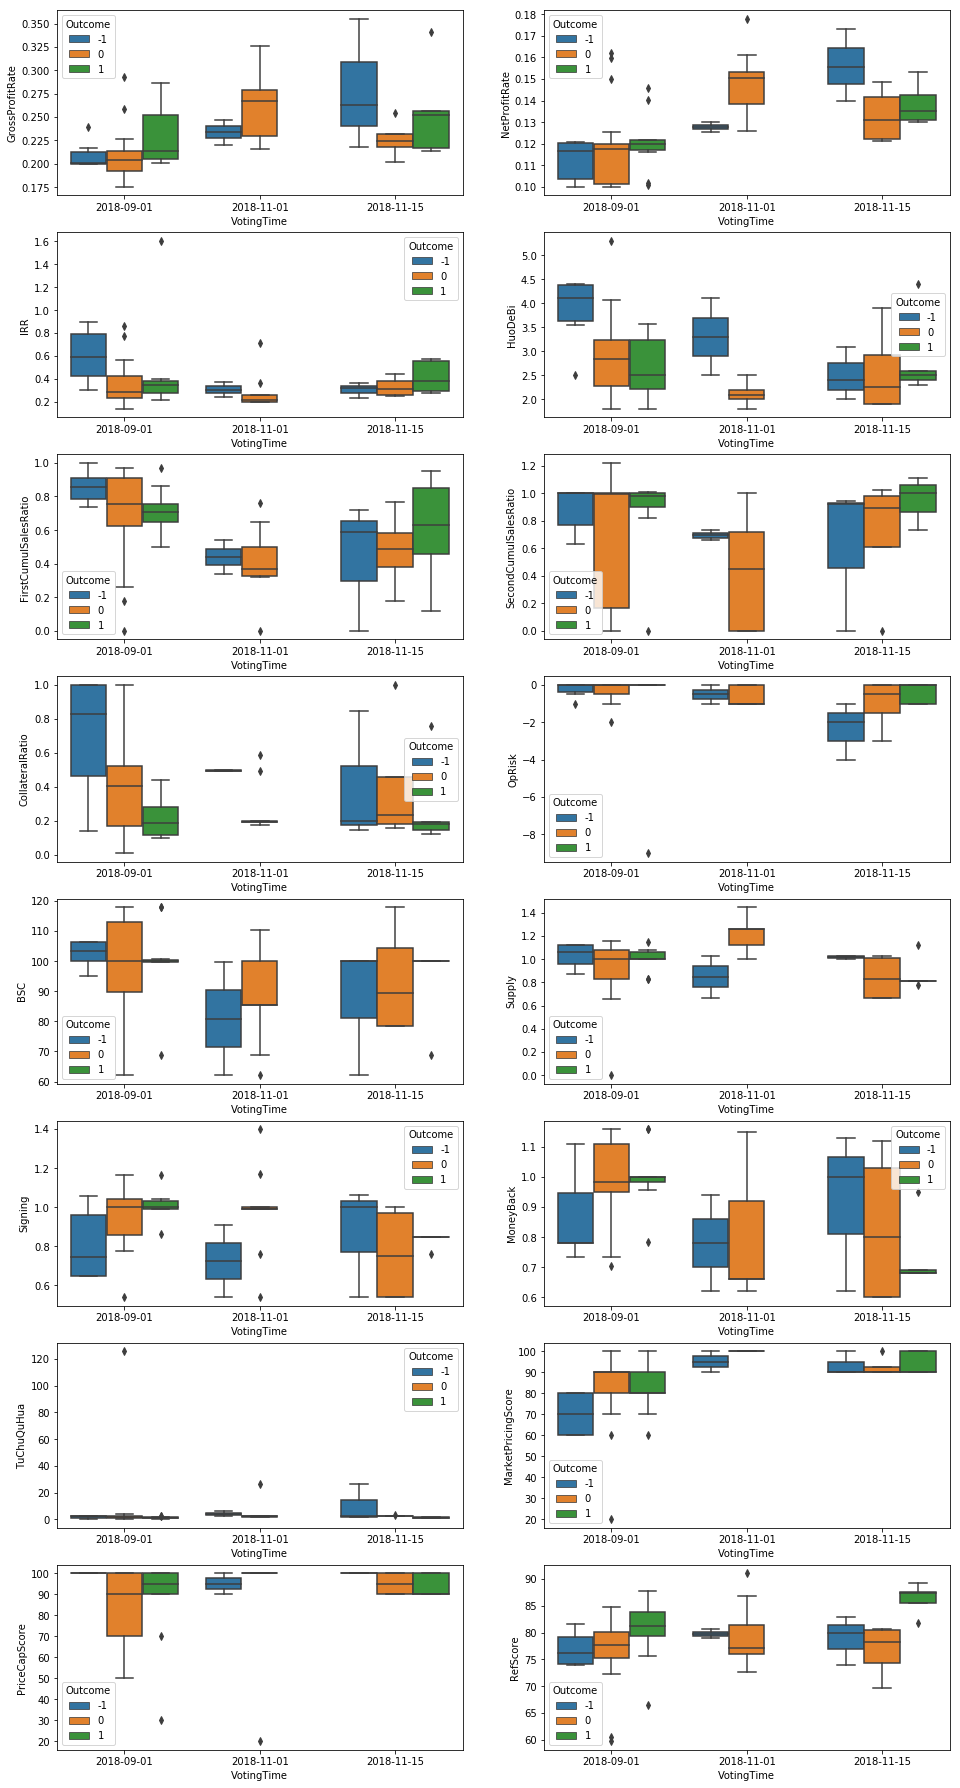

In [16]:
continuous_cols = learning_data.columns[learning_data.dtypes == np.float64]
continuous_cols

ncols = 2
nrows = (len(continuous_cols) + 1) // ncols 
fig, ax = plt.subplots(nrows,ncols,figsize=(16, 32))

for ix in range(nrows):
    for iy in range(ncols):
        i = ix*ncols+iy
        if (i < len(continuous_cols)):
            col_name = continuous_cols[i]
            sns.boxplot(x='VotingTime', y=col_name, hue='Outcome', ax=ax[ix][iy], data=learning_data)

#plt.show()            

In [17]:
categorical_features = learning_data.columns[learning_data.dtypes == np.dtype('O')].values.tolist()

#numerical_features = learning_data.columns[learning_data.dtypes.isin([np.dtype('int64'), np.dtype('float64')])]
#learning_data.loc[:, numerical_features] = learning_data.loc[:, numerical_features].astype('float32')

## drop LuoDiXing & RegionTendence, since no difference

In [18]:
sorted([(col, len(learning_data[col].value_counts())) for col in learning_data.columns], key=lambda x: x[1])

learning_data.drop(['LuoDiXing', 'RegionTendency'], axis=1, inplace=True)

learning_data.to_csv('./learning_data.csv', index=False)

In [19]:
learning_data.dtypes

City                        object
SubCompany                  object
AcquType                    object
GrossProfitRate            float64
NetProfitRate              float64
IRR                        float64
HuoDeBi                    float64
PeriodToOpening              int64
PeriodOfCashFlowBalance      int64
FirstCumulSalesRatio       float64
SecondCumulSalesRatio      float64
CollateralRatio            float64
TermOfLandPayment            int64
OpRisk                     float64
BSC                        float64
Supply                     float64
Signing                    float64
MoneyBack                  float64
QiDongHuiJiangCheng          int64
KaiPanKaoPuDu                int64
TuChuQuHua                 float64
CityEnergy                   int64
MarketTiming                object
RegionRankScore              int64
MarketPricingScore         float64
PriceCapScore              float64
SalesScore                   int64
Outcome                      int64
RefScore            

In [20]:
def get_outcome_corr(data):
    #corr = data[numerical_features + ordinal_features].corr()
    corr = data.corr()
    ds = corr['Outcome'].sort_values().drop('Outcome')
    return ds

def draw_corr(ds):    
    sns.barplot(x='index', y='Outcome', data = pd.DataFrame(ds).reset_index())
    plt.xticks(rotation=90)
    plt.grid(True)

def draw_corr_matrix(corr):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 7))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
#nominal_features = learning_data.columns[learning_data.dtypes == np.dtype('O')].values.tolist()
nominal_features = ['City', 'SubCompany', 'AcquType', 'MarketTiming']

#ordinal_features = learning_data.columns[learning_data.dtypes == np.dtype('int64')].values.tolist()
ordinal_features = ['KaiPanKaoPuDu', 'CityEnergy', 'RegionRankScore', 'SalesScore']

# numerical features
numerical_features = ['GrossProfitRate', 'NetProfitRate', 'IRR', 'HuoDeBi', 'PeriodToOpening', 'PeriodOfCashFlowBalance', 'FirstCumulSalesRatio',
 'SecondCumulSalesRatio', 'CollateralRatio', 'TermOfLandPayment', 'OpRisk', 'BSC', 'Supply', 'Signing', 'MoneyBack',
 'QiDongHuiJiangCheng', 'TuChuQuHua', 'MarketPricingScore', 'PriceCapScore', 'Outcome', 'RefScore']

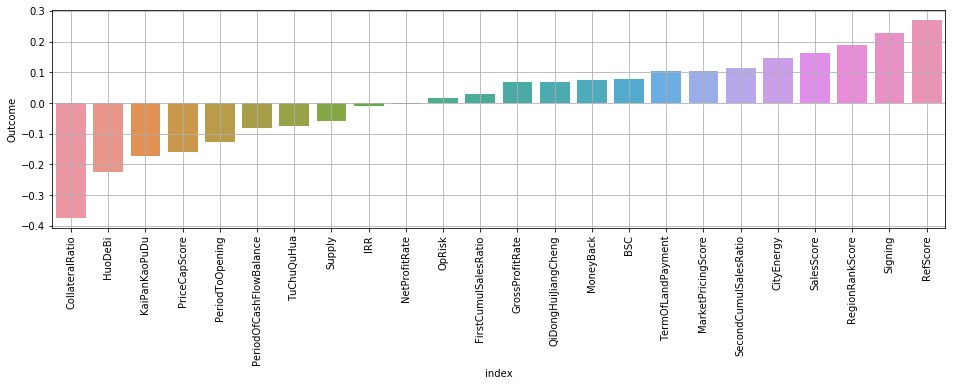

In [22]:
ds = get_outcome_corr(learning_data[numerical_features + ordinal_features])
plt.rcParams['figure.figsize'] = (16, 4)
draw_corr(ds)
#plt.show()

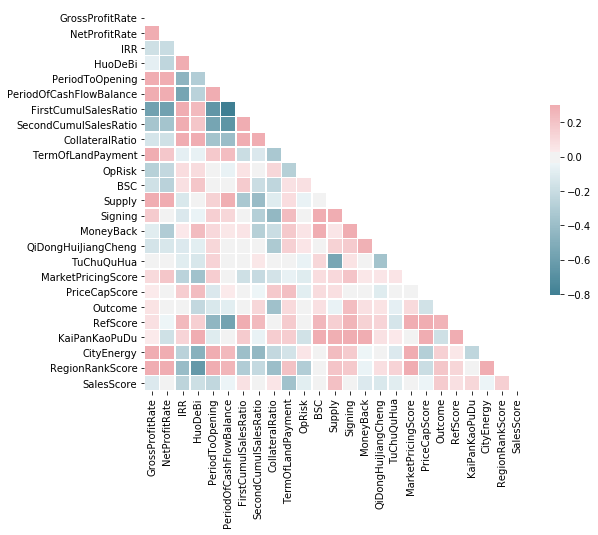

In [23]:
draw_corr_matrix(learning_data[numerical_features + ordinal_features].corr())

## Compare corr between Sept. and Nov.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

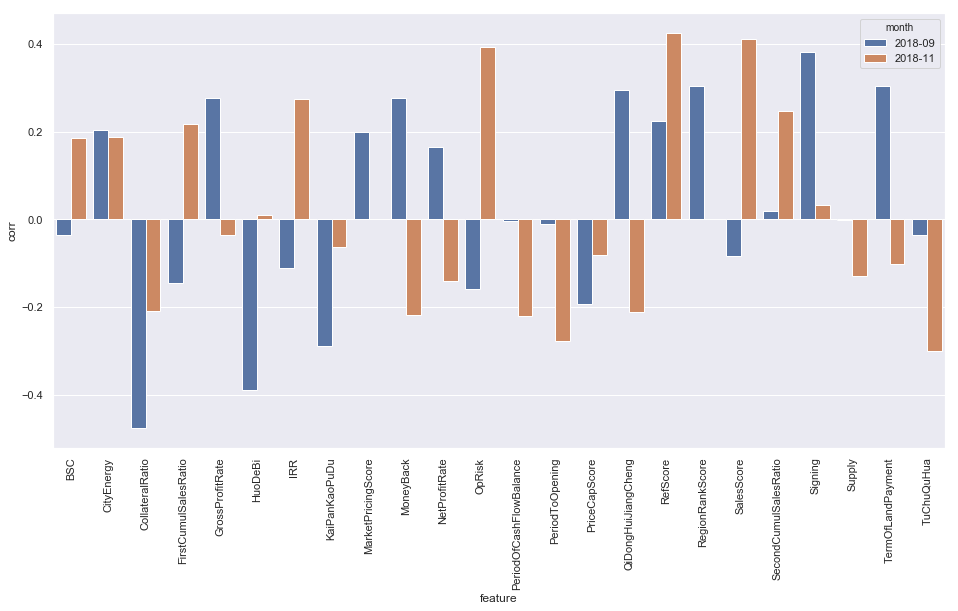

In [24]:
corrs = {}
corrs['2018-09'] = get_outcome_corr(learning_data.query('VotingTime == "2018-09-01"')[numerical_features + ordinal_features])
corrs['2018-11'] = get_outcome_corr(learning_data.query('VotingTime != "2018-09-01"')[numerical_features + ordinal_features])

df = pd.DataFrame(corrs)
data = pd.DataFrame([(row.name, row[col], col) for _, row in df.iterrows() for col in df.columns],
                   columns = ['feature','corr','month'])

plt.rcParams['figure.figsize'] = (16, 8)
sns.set(color_codes=True)
sns.barplot(x="feature", y="corr", hue='month', data=data)
plt.xticks(rotation=90)

## Compare corr with additional nominal features

In [25]:
learning_data_labeled = pd.get_dummies(learning_data, columns=['SubCompany', 'AcquType', 'MarketTiming'])
learning_data_labeled.head()

,City,GrossProfitRate,NetProfitRate,IRR,HuoDeBi,PeriodToOpening,PeriodOfCashFlowBalance,FirstCumulSalesRatio,SecondCumulSalesRatio,CollateralRatio,...,SubCompany_SZ1,SubCompany_XA,SubCompany_XCSC,SubCompany_ZJ,AcquType_GKSC,AcquType_SBG,AcquType_ZPG,MarketTiming_GWPZ,MarketTiming_L,MarketTiming_LW
0,QD,0.214200,0.120300,0.285400,2.63,9,15,0.931,1.036,0.740000,...,0,0,0,0,0,0,1,0,1,0
1,QD,0.214500,0.120000,0.237000,3.00,11,18,0.700,0.860,0.742622,...,0,0,0,0,0,0,1,0,1,0
2,JZ,0.286400,0.140100,0.382900,3.21,4,17,0.765,1.008,0.100600,...,0,0,0,0,0,1,0,0,1,0
3,GZ1,0.237406,0.101753,0.362042,3.25,6,16,0.640,1.004,0.250400,...,0,0,0,0,0,1,0,0,1,0
4,GZ1,0.269580,0.100875,0.402111,3.57,6,16,0.613,1.001,0.292700,...,0,0,0,0,0,1,0,0,1,0


In [26]:
get_outcome_corr(learning_data_labeled.query('VotingTime != "2018-09-01"').drop('VotingTime', axis=1))

SubCompany_DL             -3.915780e-01
SubCompany_NJ             -3.233349e-01
SubCompany_FZ             -3.233349e-01
TuChuQuHua                -3.015181e-01
PeriodToOpening           -2.784008e-01
SubCompany_SZ1            -2.340126e-01
PeriodOfCashFlowBalance   -2.208301e-01
MoneyBack                 -2.182707e-01
QiDongHuiJiangCheng       -2.115773e-01
CollateralRatio           -2.089879e-01
NetProfitRate             -1.413873e-01
MarketTiming_L            -1.384437e-01
Supply                    -1.288074e-01
TermOfLandPayment         -1.024377e-01
PriceCapScore             -8.066204e-02
KaiPanKaoPuDu             -6.234349e-02
GrossProfitRate           -3.604705e-02
AcquType_SBG              -1.630271e-17
RegionRankScore            0.000000e+00
MarketPricingScore         0.000000e+00
AcquType_GKSC              0.000000e+00
SubCompany_ZJ              0.000000e+00
SubCompany_SN              0.000000e+00
SubCompany_BJ              0.000000e+00
SubCompany_QD              0.000000e+00


In [27]:
corrs_Labeled = {}
corrs_Labeled['2018-09'] = get_outcome_corr(learning_data_labeled.query('VotingTime == "2018-09-01"').drop('VotingTime', axis=1)).dropna()
corrs_Labeled['2018-11'] = get_outcome_corr(learning_data_labeled.query('VotingTime != "2018-09-01"').drop('VotingTime', axis=1)).dropna()
                                            
df = pd.DataFrame(corrs_Labeled)
data = pd.DataFrame([(row.name, row[col], col) for _, row in df.iterrows() for col in df.columns],
                   columns = ['feature','corr','month'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]), <a list of 52 Text xticklabel objects>)

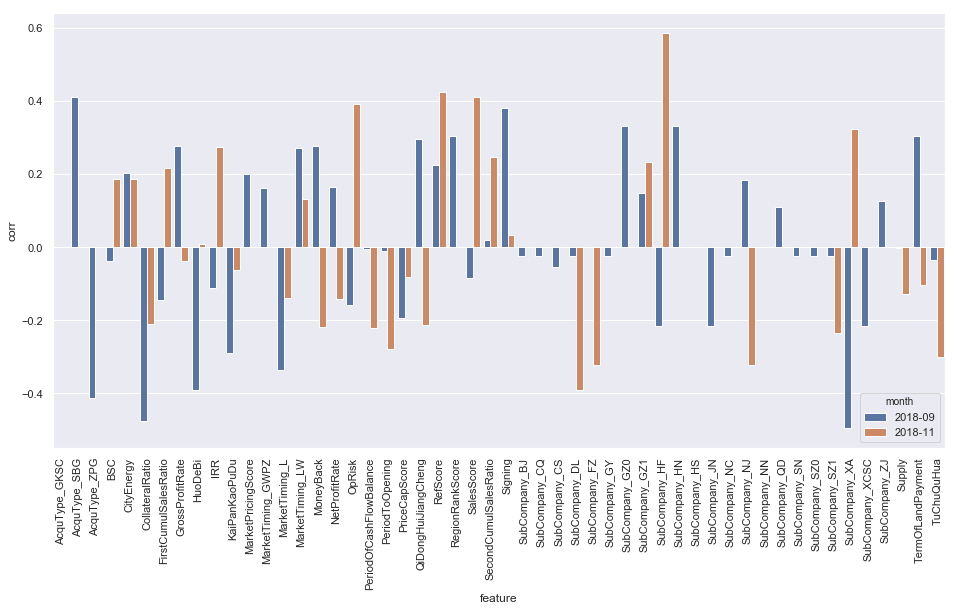

In [28]:
plt.rcParams['figure.figsize'] = (16, 8)
sns.set(color_codes=True)
sns.barplot(x="feature", y="corr", hue='month', data=data)
plt.xticks(rotation=90)

In [29]:
corrs['2018-09'], corrs['2018-11']

(CollateralRatio           -0.476759
 HuoDeBi                   -0.389718
 KaiPanKaoPuDu             -0.288507
 PriceCapScore             -0.192641
 OpRisk                    -0.158400
 FirstCumulSalesRatio      -0.144722
 IRR                       -0.111526
 SalesScore                -0.084392
 BSC                       -0.036098
 TuChuQuHua                -0.035524
 PeriodToOpening           -0.011045
 PeriodOfCashFlowBalance   -0.003958
 Supply                    -0.001991
 SecondCumulSalesRatio      0.020432
 NetProfitRate              0.164920
 MarketPricingScore         0.200074
 CityEnergy                 0.204729
 RefScore                   0.224750
 GrossProfitRate            0.276326
 MoneyBack                  0.277075
 QiDongHuiJiangCheng        0.295361
 RegionRankScore            0.305312
 TermOfLandPayment          0.305827
 Signing                    0.381754
 Name: Outcome, dtype: float64, TuChuQuHua                -0.301518
 PeriodToOpening           -0.278401
 Period

In [30]:
corrs_Labeled['2018-09'][abs(corrs_Labeled['2018-09']) > 0.2], corrs_Labeled['2018-11'][abs(corrs_Labeled['2018-11']) > 0.2]

(SubCompany_XA         -0.495012
 CollateralRatio       -0.476759
 AcquType_ZPG          -0.412510
 HuoDeBi               -0.389718
 MarketTiming_L        -0.334633
 KaiPanKaoPuDu         -0.288507
 SubCompany_JN         -0.216306
 SubCompany_XCSC       -0.216306
 SubCompany_HF         -0.216306
 MarketPricingScore     0.200074
 CityEnergy             0.204729
 RefScore               0.224750
 MarketTiming_LW        0.272686
 GrossProfitRate        0.276326
 MoneyBack              0.277075
 QiDongHuiJiangCheng    0.295361
 RegionRankScore        0.305312
 TermOfLandPayment      0.305827
 SubCompany_HN          0.332779
 SubCompany_GZ0         0.332779
 Signing                0.381754
 AcquType_SBG           0.412510
 Name: Outcome, dtype: float64, SubCompany_DL             -0.391578
 SubCompany_NJ             -0.323335
 SubCompany_FZ             -0.323335
 TuChuQuHua                -0.301518
 PeriodToOpening           -0.278401
 SubCompany_SZ1            -0.234013
 PeriodOfCashFlowBala

# Modelling
* training set: 2018-09
* testing set: 2018-11

In [31]:
learning_data = pd.read_csv('./learning_data.csv')

In [32]:
X = pd.get_dummies(
    learning_data[numerical_features + ordinal_features + ['AcquType', 'MarketTiming']]
    .drop(['Outcome', 'RefScore'], axis=1))
y_outcome = learning_data['Outcome'].astype('float32').values
y_score = learning_data['RefScore'].astype('float32').values

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)
y_score_scaled = preprocessing.minmax_scale(y_score)

X_train = X_scaled[learning_data['VotingTime'] == "2018-09-01"]
y_outcome_train = y_outcome[learning_data['VotingTime'] == "2018-09-01"]
y_score_train = y_score_scaled[learning_data['VotingTime'] == "2018-09-01"]

X_test = X_scaled[learning_data['VotingTime'] != "2018-09-01"]
y_outcome_test = y_outcome[learning_data['VotingTime'] != "2018-09-01"]
y_score_test = y_score_scaled[learning_data['VotingTime'] != "2018-09-01"]

In [33]:
def train_model(x, y, m):
    res = m.fit(x, y)    
    return res

def model2dict(m, cols):
    d = dict(filter(lambda x: not np.allclose(x[1], 0), zip(cols, m.coef_)))
    d['alpha'] = m.alpha
    return d

In [34]:
def ndcg(y_pred, y_out, K):
    #df = pd.DataFrame(np.array([y_pred, y_out]).T, columns= ['score', 'rating'])
    df = pd.DataFrame([y_pred, y_out], index=['score', 'rating']).transpose()
    dcg = 0
    idx = 0
    for _, row in df.sort_index(by='score', ascending=False).iterrows():        
        if idx < K:
            dcg += (np.power(2.0, row['rating'] + 1) - 1) / np.log2(idx+2)
            #print('DCG: ', idx, row['rating'], row['score'], dcg)
        idx += 1    
    
    idcg = 0
    for i, r in enumerate(sorted(y_out, reverse=True)):
        idcg += (np.power(2, r + 1) - 1) / np.log2(i+2)
        #print('IDCG: ', i, r, idcg)
    
    ndcg = dcg / idcg
    return ndcg

def mean_ap(y_pred, y_out):
    """mean average precision"""
    #df = pd.DataFrame(np.array([y_pred, y_out]).T, columns= ['score', 'rating'])
    df = pd.DataFrame([y_pred, y_out], index=['score', 'rating']).transpose()
    res = 0
    cnt = 0
    idx = 0
    for i, row in df.sort_index(by='score', ascending=False).iterrows():
        if row['rating'] > 0.5:    # 参拍
            cnt += 1
            res += cnt / (idx+1)
            #print(idx, row['rating'], cnt, res)
        idx += 1    
    
    return res / cnt

In [35]:
def merge_not_approved(y):
    tmp = y.flatten()
    tmp[tmp < 0.5] = 0
    return tmp

In [36]:
def eval_by_corr(y_b, y_s, y_o, plot=False):
    y_df = pd.DataFrame([y_b, y_s, y_o], index=['Bar', 'Score', 'Outcome']).transpose()
    if plot:
        sns.pairplot(y_df)
    
        fig, ax = plt.subplots(1, 2)
        sns.boxplot(y='Bar', x='Outcome', data=y_df, ax=ax[0])
        sns.boxplot(y='Score', x='Outcome', data=y_df, ax=ax[1])
    
    corr = y_df.corr()['Outcome'].drop('Outcome')
    
    if plot:
        plt.figure()
        #plt.rcParams['figure.figsize'] = (8, 6)
        sns.barplot(x='index', y='Outcome', data = corr.reset_index())
        plt.xticks(rotation=90)
        plt.grid(True)
    
    #print(y_df.sort_index(by='Bar', ascending=False).head(20))
    
    eval_res = {}
    eval_res['Corr'] = corr.to_dict()
    eval_res['NDCG@5'] = { 
        'Bar': ndcg(y_b, y_o, 5), 
        'Score': ndcg(y_s, y_o, 5),
    }
    eval_res['NDCG@10'] = {     
         'Bar': ndcg(y_b, y_o, 10),          
         'Score': ndcg(y_s, y_o, 10)}
    eval_res['MAP'] = {  
        'Bar': mean_ap(y_b, y_o),         
        'Score': mean_ap(y_s, y_o)}
    
    return eval_res

## Train a Linear Model

In [37]:
# using 2018-09
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_09 = train_model(X_train, y_outcome_train, lasso)
model2dict(model_09, X.columns.values)

y_bar = model_09.predict(X_train)
eval = eval_by_corr(y_b=y_bar, y_s=y_score_train, y_o=y_outcome_train)
eval['Model'] = 'model_09'
#print(eval)

# using 2018-11
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_11 = train_model(X_test, y_outcome_test, lasso)
model2dict(model_11, X.columns.values)

y_bar = model_11.predict(X_test)
eval = eval_by_corr(y_b=y_bar, y_s=y_score_test, y_o=y_outcome_test)
eval['Model'] = 'model_11'
#print(eval)

# using all data
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_all = train_model(X_scaled, y_outcome, lasso)
y_bar = model_all.predict(X_scaled)
eval = eval_by_corr(y_b=y_bar, y_o=y_outcome, y_s=y_score_scaled)
eval['Model'] = 'model_all'
#print(eval)

## Test extrapolation perf 

In [38]:
# using 2018-09 over 2018-11
y_bar = model_09.predict(X_test)
#print(eval_by_corr(y_b=y_bar, y_s=y_score_test, y_o=y_outcome_test))

# using 2018-11 over 2018-09
y_bar = model_11.predict(X_train)
#print(eval_by_corr(y_b=y_bar, y_s=y_score_train, y_o=y_outcome_train))

# model_all over 2018-09
y_bar = model_all.predict(X_train)
#print(eval_by_corr(y_b=y_bar, y_s=y_score_train, y_o=y_outcome_train))

# model_all over 2019-11 
y_bar = model_all.predict(X_test)
#print(eval_by_corr(y_b=y_bar, y_s=y_score_test, y_o=y_outcome_test))

# Train a Linear Model with  ‘通过’ & ‘否决’ merged

In [39]:
# using 2018-09
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_09 = train_model(X_train, merge_not_approved(y_outcome_train), lasso)
model2dict(model_09, X.columns.values)

y_bar = model_09.predict(X_train)
eval = eval_by_corr(y_b=y_bar, y_s=y_score_train, y_o=merge_not_approved(y_outcome_train))
eval['Model'] = 'model_09'
#print(eval)

# using 2018-11
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_11 = train_model(X_test, merge_not_approved(y_outcome_test), lasso)
model2dict(model_11, X.columns.values)

y_bar = model_11.predict(X_test)
eval = eval_by_corr(y_b=y_bar, y_s=y_score_test, y_o=merge_not_approved(y_outcome_test))
eval['Model'] = 'model_11'
#print(eval)

# using all data
lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model_all = train_model(X_scaled, merge_not_approved(y_outcome), lasso)
y_bar = model_all.predict(X_scaled)
eval = eval_by_corr(y_b=y_bar, y_s=y_score_scaled, y_o=merge_not_approved(y_outcome))
eval['Model'] = 'model_all'
#print(eval)

In [40]:
m = {'2018-09': None, '2018-11': None}
m['2018-09'] = model2dict(cols=X.columns.values, m=model_09)
m['2018-11'] = model2dict(cols=X.columns.values, m=model_11)
m['all'] = model2dict(cols=X.columns.values, m=model_all)
pd.DataFrame(m)

,2018-09,2018-11,all
AcquType_SBG,0.045977,NaN,NaN
MarketTiming_L,-0.012644,NaN,NaN
SecondCumulSalesRatio,NaN,0.064078,NaN
alpha,0.050000,0.050000,0.05


## Training batch of Regression Model

In [41]:
model_list = {
              'Linear': LinearRegression(),
              #AdaBoostRegressor(base_estimator = make_pipeline(RobustScaler(), Lasso())),
              #AdaBoostRegressor(base_estimator = DecisionTreeRegressor()),
              #AdaBoostRegressor(base_estimator = lgb.LGBMRegressor()),
              'Lasso': Lasso(max_iter=1000, alpha=0.05),
              'L1+L2': ElasticNet(alpha=0.05),
              'GradientBoosting': GradientBoostingRegressor(),
              'DT': DecisionTreeRegressor(),
              'RF': RandomForestRegressor(),
              'XGBoost': xgb.XGBRegressor(),
              'LightGBM': lgb.LGBMRegressor(min_data=1, min_data_in_bin=1),
            }

In [42]:
intra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train, 
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-09', 'X': X_train,     
               'y_score': y_score_train, 'y_out': y_outcome_train}},
    {'train': {'Dataset': '2018-11', 'X': X_test,     
               'y_score': y_score_test, 'y_out': y_outcome_test },    
     'test': {'Dataset': '2018-11', 'X': X_test,              
             'y_score': y_score_test, 'y_out': y_outcome_test}}
]

extra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test}},
    {'train':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test},
     'test': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train}}
]

In [43]:
def model_feature_importance(model, features):
    if hasattr(model, 'coef_'):
        return dict(zip(features, getattr(model, 'coef_')))
    elif hasattr(model, 'feature_importances_'):
        return dict(zip(features, getattr(model, 'feature_importances_')))

def train_eval_regression_models(models, datasets, features):
    evals = {}
    ms = []
    for ds in datasets:
        train_ds = ds['train']
        test_ds = ds['test']
        for mname, rm in models.items():
            #mname = str(rm.__class__).split('.')[-1][:-2]
            m = train_model(m=rm, x=train_ds['X'], y=train_ds['y_out'])
            y_bar = m.predict(test_ds['X'])
            evaluation = eval_by_corr(y_b=y_bar, y_s=test_ds['y_score'], y_o=test_ds['y_out'])
                
            #ms[(train_ds['Dataset'],     # 'TtrainDataset' 
            #    test_ds['Dataset'],      # 'TestDataset'
            #       mname)                # 'Model'                      
            #     ] = m
            ms.append(((train_ds['Dataset'], test_ds['Dataset'], mname), model_feature_importance(m, features)))
            #if mname=='XGBoost':
            #    print((train_ds['Dataset'], test_ds['Dataset'], mname), m.feature_importances_)
            #evals.append(evaluation)
            evaluation = pd.DataFrame(evaluation).transpose().to_dict()
            evals[(train_ds['Dataset'],  # 'TtrainDataset' 
                   test_ds['Dataset'],   # 'TestDataset'
                   mname)                # 'Model'                      
                 ] = evaluation['Bar']
    
            evals[(train_ds['Dataset'],  # 'TtrainDataset' 
                   test_ds['Dataset'],   # 'TestDataset'
                   'RefScore')           # 'Model'                      
                 ] = evaluation['Score']
        
    e_df = pd.DataFrame(evals)
    e_df.columns.names = ['TrainDataset', 'TestDataset', 'Model']
    
    m_df = pd.DataFrame(dict(ms))
    #m_df = pd.DataFrame({k: model_feature_importance(v, features) for k, v in ms.items() })
    m_df.columns.names = ['TrainDataset', 'TestDataset', 'Model']
    m_df.index.name = 'Metric'
    return (e_df.transpose().sort_index(), m_df)

def show_model_variance(m_df):
    for m in ['XGBoost', 'RF', 'Linear']:
        plt.rcParams['figure.figsize'] = (16, 4)
        cols = [col for col in m_df.columns.tolist() if col[-1] == m]
        m_df.sort_values(by=cols[0], ascending=False)[cols].plot.bar(title=m)
        plt.gca().legend([str(col[:2]) for col in cols])
        plt.gca().set_xlabel('')

In [44]:
eval_df, m_df = train_eval_regression_models(models=model_list, datasets=intra_datasets, features=X.columns.tolist())

## feature importances

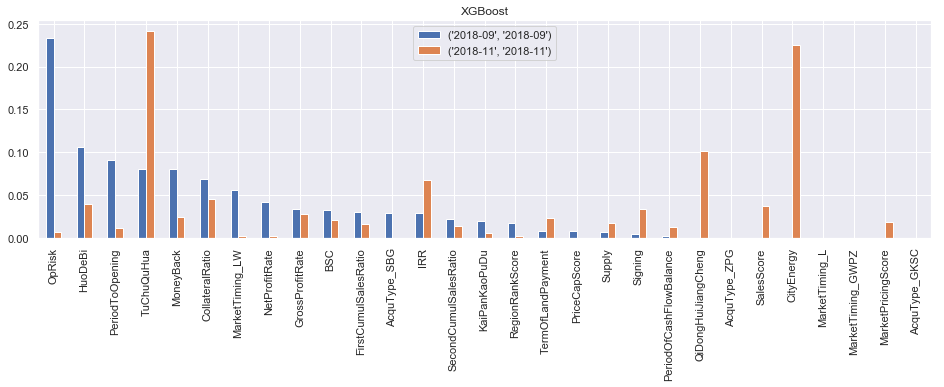

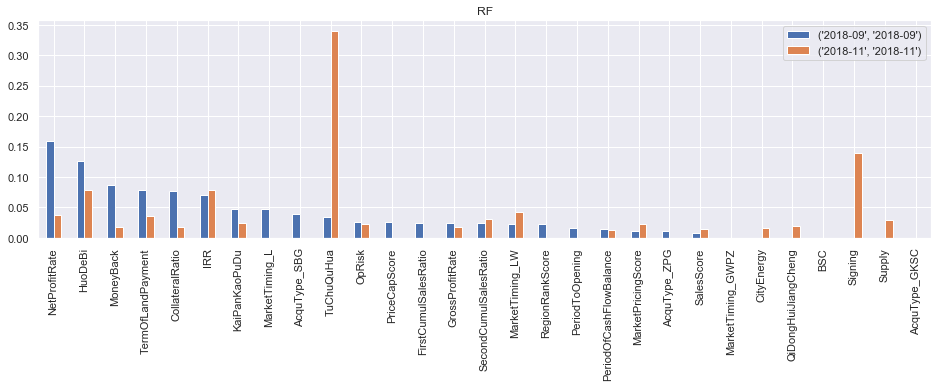

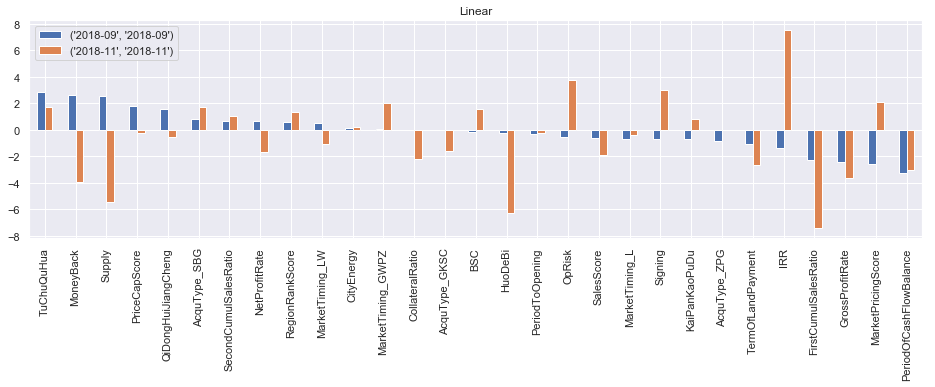

In [45]:
show_model_variance(m_df)

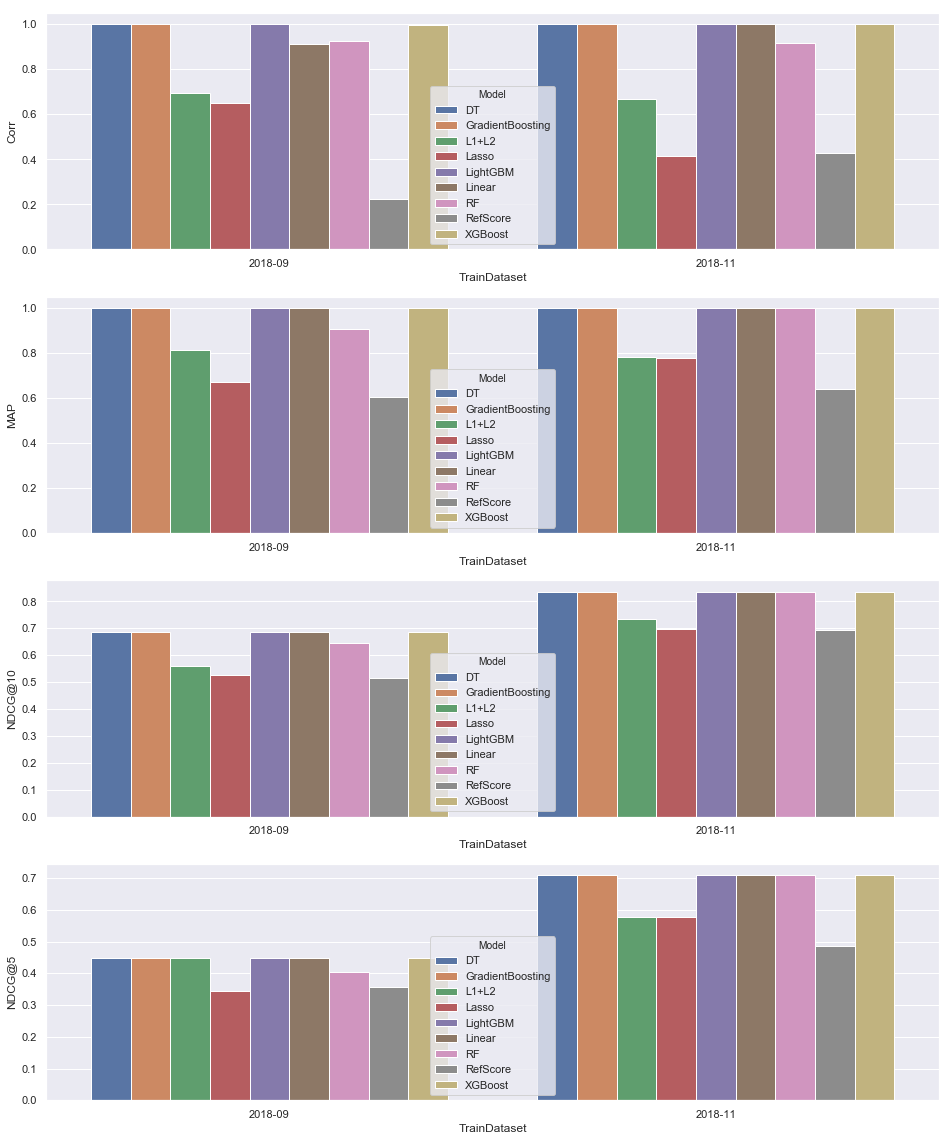

In [46]:
metrics = eval_df.columns.tolist()
plt.rcParams['figure.figsize'] = (16, 20)
fig, axes = plt.subplots(4, 1)
for i in range(len(axes)):
    sns.barplot(x='TrainDataset', y= metrics[i], hue='Model', data=eval_df.reset_index(), ax=axes[i])

In [47]:
eval_df

Corr       MAP   NDCG@10  \
TrainDataset TestDataset Model                                            
2018-09      2018-09     DT                1.000000  1.000000  0.688293   
                         GradientBoosting  0.999897  1.000000  0.688293   
                         L1+L2             0.695035  0.811980  0.559060   
                         Lasso             0.652342  0.670391  0.525911   
                         LightGBM          1.000000  1.000000  0.688293   
                         Linear            0.911646  1.000000  0.688293   
                         RF                0.926596  0.906346  0.644798   
                         RefScore          0.224750  0.605375  0.514965   
                         XGBoost           0.999075  1.000000  0.688293   
2018-11      2018-11     DT                1.000000  1.000000  0.836702   
                         GradientBoosting  1.000000  1.000000  0.836702   
                         L1+L2             0.668218  0.780952  0.735929   
                         Lasso             0.413204  0.779798  0.698657   
                         LightGBM          1.000000  1.000000  0.836702   
                         Linear            1.000000  1.000000  0.836702   
                         RF                0.915821  1.000000  0.836702   
                         RefScore          0.426338  0.641667  0.695359   
                         XGBoost           0.999991  1.000000  0.836702   

                                             NDCG@5  
TrainDataset TestDataset Model                       
2018-09      2018-09     DT                0.446655  
                         GradientBoosting  0.446655  
                         L1+L2             0.446655  
                         Lasso             0.343867  
                         LightGBM          0.446655  
                         Linear            0.446655  
                         RF                0.403160  
                         RefScore          0.357090  
                         XGBoost           0.446655  
2018-11      2018-11     DT                0.708870  
                         GradientBoosting  0.708870  
                         L1+L2             0.577836  
                         Lasso             0.577836  
                         LightGBM          0.708870  
                         Linear            0.708870  
                         RF                0.708870  
                         RefScore          0.486585  
                         XGBoost           0.708870

In [48]:
eval_df, m_df = train_eval_regression_models(models=model_list, datasets=extra_datasets, features=X.columns.tolist())

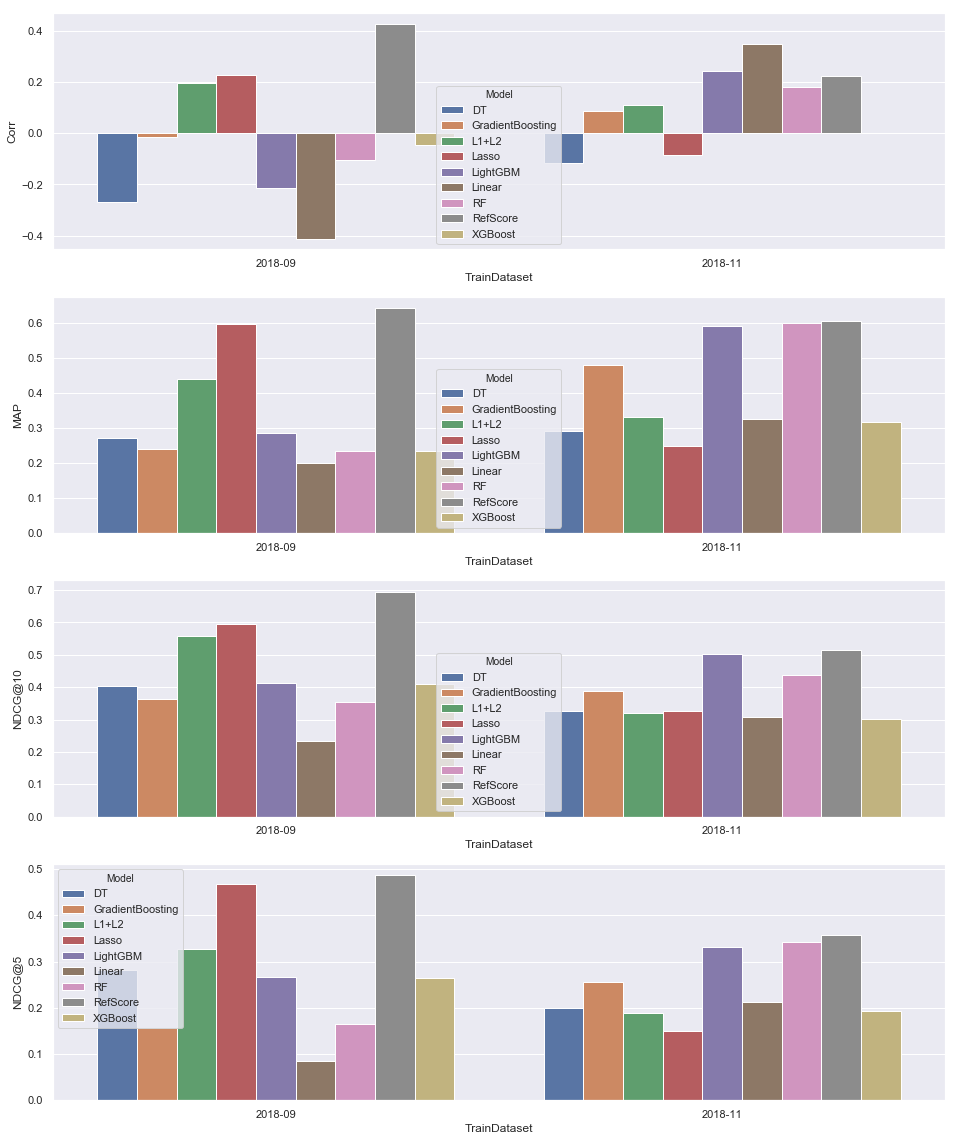

In [49]:
metrics = eval_df.columns.tolist()
plt.rcParams['figure.figsize'] = (16, 20)
fig, axes = plt.subplots(4, 1)
for i in range(len(axes)):
    sns.barplot(x='TrainDataset', y= metrics[i], hue='Model', data=eval_df.reset_index(), ax=axes[i])

# Training Classification Model

In [50]:
learning_data = pd.read_csv('./learning_data.csv')

X = pd.get_dummies(
    learning_data[numerical_features + ordinal_features + ['AcquType', 'MarketTiming']]
    .drop(['Outcome', 'RefScore'], axis=1))
y_outcome = (learning_data['Outcome'] + 1).values
y_score = learning_data['RefScore'].astype('float32').values

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)
y_score_scaled = preprocessing.minmax_scale(y_score)

X_train = X_scaled[learning_data['VotingTime'] == "2018-09-01"]
y_outcome_train = y_outcome[learning_data['VotingTime'] == "2018-09-01"]
y_score_train = y_score_scaled[learning_data['VotingTime'] == "2018-09-01"]

X_test = X_scaled[learning_data['VotingTime'] != "2018-09-01"]
y_outcome_test = y_outcome[learning_data['VotingTime'] != "2018-09-01"]
y_score_test = y_score_scaled[learning_data['VotingTime'] != "2018-09-01"]

In [51]:
classifiers = {
    'DT': DecisionTreeClassifier(max_depth = 5),
    'RF': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    'SVC': SVC(kernel = 'linear', C = 1, probability=True),
    'GaussianNB': GaussianNB(),
    'MLP': MLPClassifier()
}

In [52]:
intra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train, 
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-09', 'X': X_train,     
               'y_score': y_score_train, 'y_out': y_outcome_train}},
    {'train': {'Dataset': '2018-11', 'X': X_test,     
               'y_score': y_score_test, 'y_out': y_outcome_test },    
     'test': {'Dataset': '2018-11', 'X': X_test,              
             'y_score': y_score_test, 'y_out': y_outcome_test}}
]

extra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test}},
    {'train':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test},
     'test': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train}}
]

In [53]:
def train_eval_classification_models(classifiers, dataset):
    vtime = dataset['train']['Dataset']
    X_train = dataset['train']['X']
    y_s_train = dataset['train']['y_score']
    y_train = dataset['train']['y_out']
    
    X_test = dataset['test']['X']
    y_s_test = dataset['test']['y_score']
    y_test = dataset['test']['y_out']
    
    evals = {}
    for cname, cm in classifiers.items():
        c = cm.fit(X_train, y_train)
        y_pred = c.predict(X_test)
        y_pred_proba = c.predict_proba(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        print(cname)
        #print(y_pred_proba[:,-1])
        
        #print(classification_report(y_test, y_pred, target_names=['class0', 'class1', 'class2']))
        
        #rep = pd.DataFrame(np.array(precision_recall_fscore_support(y, y_pred)),                         
        #                   index=['precision', 'recall', 'f1-score', 'support']).transpose()
        #rep['Model'] = cname
        #print(rep)        
        
        evaluation = eval_by_corr(y_b=y_pred_proba[:,-1], y_s=y_s_test, y_o=y_test)
        print(pd.DataFrame(evaluation))
        
        if hasattr(c, 'feature_importances_'):
            print(getattr(c, 'feature_importances_'))
            
        evaluation = pd.DataFrame(evaluation).transpose().to_dict()
        evals[(dataset['train']['Dataset'],  # 'TtrainDataset' 
                   dataset['test']['Dataset'],   # 'TestDataset'
                   cname)                        # 'Model'                      
                 ] = evaluation['Bar']
    
        evals[(dataset['train']['Dataset'],  # 'TtrainDataset' 
                   dataset['test']['Dataset'],   # 'TestDataset'
                   'RefScore')           # 'Model'                      
                 ] = evaluation['Score']
        
    e_df = pd.DataFrame(evals)
    e_df.columns.names = ['TrainDataset', 'TestDataset', 'Model']
    return e_df.transpose()

In [54]:
train_eval_classification_models(classifiers, intra_datasets[0])

DT
           Corr    NDCG@5   NDCG@10       MAP
Bar    0.716651  0.401282  0.547947  0.995665
Score  0.224750  0.332311  0.484898  0.914377
[0.         0.         0.09322034 0.         0.08286252 0.
 0.10393532 0.         0.         0.41071267 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.20989535 0.         0.         0.         0.0993738 ]
RF
           Corr    NDCG@5   NDCG@10       MAP
Bar    0.718735  0.401282  0.593839  0.964820
Score  0.224750  0.332311  0.484898  0.914377
[0.03446974 0.06175748 0.04103979 0.0810512  0.05818823 0.01515328
 0.03212192 0.02628477 0.05766118 0.11221086 0.00954704 0.01244257
 0.01015158 0.0370801  0.06080835 0.01404423 0.02865242 0.06396307
 0.01078024 0.03193313 0.02551622 0.01805839 0.         0.
 0.04987155 0.08125643 0.00405983 0.00768906 0.01420732]
SVC
           Corr    NDCG@5   NDCG@10       MAP
Bar    0.727127  0.401282  0.571358  0.980872
Score  0.224

Corr       MAP   NDCG@10    NDCG@5
TrainDataset TestDataset Model                                             
2018-09      2018-09     DT          0.716651  0.995665  0.547947  0.401282
                         RefScore    0.224750  0.914377  0.484898  0.332311
                         RF          0.718735  0.964820  0.593839  0.401282
                         SVC         0.727127  0.980872  0.571358  0.401282
                         GaussianNB  0.606140  0.968927  0.571358  0.401282
                         MLP         0.753189  0.966271  0.572481  0.401282

# Summary of Ranking Models 

In [55]:
learning_data = pd.read_csv('./learning_data.csv')

X = pd.get_dummies(
    learning_data[numerical_features + ordinal_features + ['AcquType', 'MarketTiming']]
    .drop(['Outcome', 'RefScore'], axis=1))
y_outcome = (learning_data['Outcome'] + 1).values
y_score = learning_data['RefScore'].astype('float32').values

X_scaled = preprocessing.MinMaxScaler().fit_transform(X)
y_score_scaled = preprocessing.minmax_scale(y_score)

X_train = X_scaled[learning_data['VotingTime'] == "2018-09-01"]
y_outcome_train = y_outcome[learning_data['VotingTime'] == "2018-09-01"]
y_score_train = y_score_scaled[learning_data['VotingTime'] == "2018-09-01"]

X_test = X_scaled[learning_data['VotingTime'] != "2018-09-01"]
y_outcome_test = y_outcome[learning_data['VotingTime'] != "2018-09-01"]
y_score_test = y_score_scaled[learning_data['VotingTime'] != "2018-09-01"]

intra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train, 
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-09', 'X': X_train,     
               'y_score': y_score_train, 'y_out': y_outcome_train}},
    {'train': {'Dataset': '2018-11', 'X': X_test,     
               'y_score': y_score_test, 'y_out': y_outcome_test },    
     'test': {'Dataset': '2018-11', 'X': X_test,              
             'y_score': y_score_test, 'y_out': y_outcome_test}}
]

extra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test}},
    {'train':  {'Dataset': '2018-11', 'X': X_test,
               'y_score': y_score_test, 'y_out': y_outcome_test},
     'test': {'Dataset': '2018-09', 'X': X_train,
               'y_score': y_score_train, 'y_out': y_outcome_train}}
]

In [56]:
class RankingModel:
    def __init__(self, model, category):
        self._model = model
        self._cat = category        
        
    @property
    def model(self):
        return self._model
    
    @property
    def category(self):
        return self._cat
    
    def fit(self, X, y):
        self._model.fit(X, y)      
        return self
    
    def predict(self, X):
        if self.category == 'Regression':
            return self.model.predict(X)
        elif self.category == 'Classification':
            return self.model.predict_proba(X)[:,-1]
        else:
            return None
    
    @property
    def feature_importances(self):
        if self.category == 'Regression':        
            if hasattr(self.model, 'coef_'):
                return getattr(self.model, 'coef_')
            elif hasattr(self.model, 'feature_importances_'):
                return getattr(self.model, 'feature_importances_')
        elif self.category == 'Classification':
            if hasattr(self.model, 'feature_importances_'):
                return getattr(self.model, 'feature_importances_')        

In [57]:
ranking_models = {        
    'LinearReg': RankingModel(LinearRegression(), 'Regression'),    
    'LassoReg': RankingModel(Lasso(max_iter=1000, alpha=0.05), 'Regression'),             
    'GradientBoostingReg': RankingModel(GradientBoostingRegressor(), 'Regression'),
    'DTReg': RankingModel(DecisionTreeRegressor(max_depth=5), 'Regression'),
    'RFReg': RankingModel(RandomForestRegressor(n_jobs=100, max_depth=3), 'Regression'),
    'XGBoostReg': RankingModel(xgb.XGBRegressor(), 'Regression'),
    'LightGBMReg': RankingModel(lgb.LGBMRegressor(min_data=1, min_data_in_bin=1), 'Regression'),
    'DTCls': RankingModel(DecisionTreeClassifier(max_depth = 5), 'Classification'),
    'RFCls': RankingModel(RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0), 'Classification'),
    'SVCCls': RankingModel(SVC(kernel = 'linear', C = 1, probability=True), 'Classification'),
    'GaussianNBCls': RankingModel(GaussianNB(), 'Classification'),
    'MLPCls': RankingModel(MLPClassifier(), 'Classification'),            
}

In [58]:
def ndcg(y_pred, y_out, K):
    #df = pd.DataFrame(np.array([y_pred, y_out]).T, columns= ['score', 'rating'])
    df = pd.DataFrame([y_pred, y_out], index=['score', 'rating']).transpose()
    dcg = 0
    idx = 0
    for _, row in df.sort_index(by='score', ascending=False).iterrows():        
        if idx < K:
            #dcg += (np.power(2.0, row['rating'] + 1) - 1) / np.log2(idx+2)
            dcg += (np.power(2.0, row['rating']) - 1) / np.log2(idx+2)
            #print('DCG: ', idx, row['rating'], row['score'], dcg)
        idx += 1    
    
    idcg = 0
    for i, r in enumerate(sorted(y_out, reverse=True)):
        if i < K:
            idcg += (np.power(2, r) - 1) / np.log2(i+2)
            #print('IDCG: ', i, r, idcg)
    
    ndcg = dcg / idcg
    return ndcg

def mean_ap(y_pred, y_out):
    """mean average precision"""
    #df = pd.DataFrame(np.array([y_pred, y_out]).T, columns= ['score', 'rating'])
    df = pd.DataFrame([y_pred, y_out], index=['score', 'rating']).transpose()
    res = 0
    cnt = 0
    idx = 0
    for i, row in df.sort_index(by='score', ascending=False).iterrows():
        if row['rating'] > 1.5:    # 参拍
            cnt += 1
            res += cnt / (idx+1)
            #print(idx, row['rating'], cnt, res)
        idx += 1    
    
    return res / cnt

In [59]:
def train_eval_ranking_models(rankers, dataset):
    train_time = dataset['train']['Dataset']
    test_time = dataset['test']['Dataset']
    
    X_train = dataset['train']['X']
    y_s_train = dataset['train']['y_score']
    y_train = dataset['train']['y_out']
    
    X_test = dataset['test']['X']
    y_s_test = dataset['test']['y_score']
    y_test = dataset['test']['y_out']
    
    evals = {}
    ms = []
    for name, ranker in ranking_models.items():
        ranker.fit(X_train, y_train)
        y_pred = ranker.predict(X_test)
        
        evaluation = eval_by_corr(y_b=y_pred, y_s=y_s_test, y_o=y_test)        
        evaluation = pd.DataFrame(evaluation).transpose().to_dict()
        evals[(train_time, test_time, name)] = evaluation['Bar']
        evals[(train_time, test_time, 'RefScore')] = evaluation['Score']

        ms.append((train_time, test_time, name, ranker.model))
    return evals, ms

## Train & Evaluate ranking algos both INTRA & EXTRA-wise

In [60]:
intra_evals = {}
extra_evals = {}
result_models = {}

for ds in intra_datasets:
    es, ms = train_eval_ranking_models(rankers=ranking_models, dataset=ds)
    intra_evals[(ds['train']['Dataset'], ds['test']['Dataset'])] = { k[-1]:v for k, v in es.items() }
    result_models[(ds['train']['Dataset'])] = { x[2]:x[3] for x in ms }
    
for ds in extra_datasets:
    es, ms = train_eval_ranking_models(rankers=ranking_models, dataset=ds)
    extra_evals[(ds['train']['Dataset'], ds['test']['Dataset'])] = { k[-1]:v for k, v in es.items() if k[-1] !='RefScore' }    

### evaluate ranking algos by averaging intra- and extra- performances

In [61]:
overal_evals = {}

for k in result_models.keys():
    #print(k)
    intra_eval = [v for ks, v in intra_evals.items() if ks[0] == k][0]
    extra_eval = [v for ks, v in extra_evals.items() if ks[0] == k][0]
    #overal_evals[k] = (intra_eval, extra_eval)
    overal_evals[k] = {}
    for m, xs in intra_eval.items():
        for x in xs:
            if (('INTRA', x)) not in overal_evals[k]:
                overal_evals[k][('INTRA', x)] = {}
            overal_evals[k][('INTRA', x)][m] = xs[x]  
            
    for m, ys in extra_eval.items():
        for y in ys:
            if (('EXTRA', y)) not in overal_evals[k]:
                overal_evals[k][('EXTRA', y)] = {}
            overal_evals[k][('EXTRA', y)][m] = ys[y]

            
for vtime in overal_evals.keys():            
    for mt in {x[1] for x in overal_evals[vtime].keys()}:
        intra_perf = overal_evals[vtime]['INTRA', mt]
        extra_perf = overal_evals[vtime]['EXTRA', mt]
    
        averaged_perf = { m:(intra_perf[m] + extra_perf.get(m, np.NaN))/2 for m in intra_perf }
        overal_evals[vtime]['Averaged', mt] = averaged_perf

In [62]:
pd.DataFrame(overal_evals['2018-09']).sort_index(by=('Averaged', 'MAP'), ascending=False)

INTRA                                   EXTRA  \
                         Corr    NDCG@5   NDCG@10       MAP      Corr   
RFCls                0.781138  1.000000  1.000000  1.000000  0.318498   
RFReg                0.884693  1.000000  0.957586  0.962500  0.120397   
LightGBMReg          1.000000  1.000000  1.000000  1.000000 -0.214224   
GaussianNBCls        0.606140  1.000000  0.911299  0.916520       NaN   
DTCls                0.716651  1.000000  0.867129  0.913387  0.000000   
LassoReg             0.652342  0.769872  0.764080  0.670391  0.226518   
MLPCls               0.752015  1.000000  0.911299  0.954040  0.332957   
GradientBoostingReg  0.999734  1.000000  1.000000  1.000000  0.113650   
XGBoostReg           0.999530  1.000000  1.000000  1.000000 -0.032061   
SVCCls               0.740161  1.000000  0.906921  0.901324  0.130234   
LinearReg            0.911646  1.000000  1.000000  1.000000 -0.411567   
DTReg                0.956414  1.000000  0.911299  0.954040  0.078316   
RefScore             0.224750  0.799477  0.748177  0.605375       NaN   

                                                   Averaged            \
                       NDCG@5   NDCG@10       MAP       MAP      Corr   
RFCls                0.514771  0.690779  0.471209  0.735604  0.549818   
RFReg                0.413839  0.632059  0.390145  0.676322  0.502545   
LightGBMReg          0.375729  0.494552  0.285083  0.642541  0.392888   
GaussianNBCls        0.397697  0.625718  0.362526  0.639523       NaN   
DTCls                0.397697  0.625718  0.364502  0.638944  0.358326   
LassoReg             0.660840  0.712657  0.595965  0.633178  0.439430   
MLPCls               0.333333  0.553284  0.311616  0.632828  0.542486   
GradientBoostingReg  0.359383  0.486993  0.246833  0.623417  0.556692   
XGBoostReg           0.307750  0.451532  0.236405  0.618203  0.483735   
SVCCls               0.333333  0.550992  0.308217  0.604770  0.435197   
LinearReg            0.120018  0.280201  0.199184  0.599592  0.250039   
DTReg                0.262005  0.432422  0.179034  0.566537  0.517365   
RefScore                  NaN       NaN       NaN       NaN       NaN   

                                         
                      NDCG@10    NDCG@5  
RFCls                0.845390  0.757386  
RFReg                0.794823  0.706919  
LightGBMReg          0.747276  0.687865  
GaussianNBCls        0.768509  0.698849  
DTCls                0.746424  0.698849  
LassoReg             0.738368  0.715356  
MLPCls               0.732291  0.666667  
GradientBoostingReg  0.743497  0.679692  
XGBoostReg           0.725766  0.653875  
SVCCls               0.728957  0.666667  
LinearReg            0.640101  0.560009  
DTReg                0.671860  0.631002  
RefScore                  NaN       NaN

In [63]:
pd.DataFrame(overal_evals['2018-11']).sort_index(by=('Averaged', 'MAP'), ascending=False)

INTRA                                   EXTRA  \
                         Corr    NDCG@5   NDCG@10       MAP      Corr   
MLPCls               0.747284  1.000000  0.911553  1.000000  0.427000   
GradientBoostingReg  1.000000  1.000000  1.000000  1.000000 -0.011804   
RFReg                0.851127  1.000000  0.969784  1.000000  0.311690   
LightGBMReg          1.000000  1.000000  1.000000  1.000000  0.240622   
XGBoostReg           0.999983  1.000000  1.000000  1.000000  0.014125   
DTReg                1.000000  1.000000  1.000000  1.000000  0.117880   
GaussianNBCls        0.799305  1.000000  0.965882  1.000000  0.245649   
DTCls                0.799305  1.000000  0.911553  1.000000  0.292344   
LinearReg            1.000000  1.000000  1.000000  1.000000  0.346994   
RFCls                0.729502  1.000000  0.935667  1.000000 -0.061780   
LassoReg             0.413204  0.815151  0.835013  0.779798 -0.084317   
SVCCls              -0.557073  0.233072  0.360577  0.167936 -0.343420   
RefScore             0.426338  0.686423  0.831071  0.641667       NaN   

                                                   Averaged            \
                       NDCG@5   NDCG@10       MAP       MAP      Corr   
MLPCls               0.702098  0.705507  0.523564  0.761782  0.587142   
GradientBoostingReg  0.573370  0.546984  0.463239  0.731620  0.494098   
RFReg                0.559907  0.575043  0.455373  0.727687  0.581408   
LightGBMReg          0.472437  0.605382  0.415622  0.707811  0.620311   
XGBoostReg           0.518182  0.554462  0.412117  0.706059  0.507054   
DTReg                0.472437  0.605382  0.395106  0.697553  0.558940   
GaussianNBCls        0.672494  0.602334  0.356695  0.678348  0.522477   
DTCls                0.533857  0.494518  0.325532  0.662766  0.545825   
LinearReg            0.475991  0.447741  0.324274  0.662137  0.673497   
RFCls                0.262005  0.419917  0.276697  0.638348  0.333861   
LassoReg             0.333333  0.472700  0.247778  0.513788  0.164444   
SVCCls               0.276807  0.340821  0.158571  0.163253 -0.450246   
RefScore                  NaN       NaN       NaN       NaN       NaN   

                                         
                      NDCG@10    NDCG@5  
MLPCls               0.808530  0.851049  
GradientBoostingReg  0.773492  0.786685  
RFReg                0.772414  0.779953  
LightGBMReg          0.802691  0.736218  
XGBoostReg           0.777231  0.759091  
DTReg                0.802691  0.736218  
GaussianNBCls        0.784108  0.836247  
DTCls                0.703035  0.766928  
LinearReg            0.723871  0.737995  
RFCls                0.677792  0.631002  
LassoReg             0.653856  0.574242  
SVCCls               0.350699  0.254939  
RefScore                  NaN       NaN

# Impact of Subcompany

In [64]:
learning_data = pd.read_csv('./learning_data.csv')

In [65]:
X_ext = pd.get_dummies(
    learning_data[numerical_features + ordinal_features + ['AcquType', 'MarketTiming', 'SubCompany']]
    .drop(['Outcome', 'RefScore'], axis=1))
y_outcome = (learning_data['Outcome'] + 1).values
y_score = learning_data['RefScore'].astype('float32').values

X_ext_scaled = preprocessing.MinMaxScaler().fit_transform(X)
y_score_scaled = preprocessing.minmax_scale(y_score)

X_ext_train = X_ext_scaled[learning_data['VotingTime'] == "2018-09-01"]
y_outcome_train = y_outcome[learning_data['VotingTime'] == "2018-09-01"]
y_score_train = y_score_scaled[learning_data['VotingTime'] == "2018-09-01"]

X_ext_test = X_ext_scaled[learning_data['VotingTime'] != "2018-09-01"]
y_outcome_test = y_outcome[learning_data['VotingTime'] != "2018-09-01"]
y_score_test = y_score_scaled[learning_data['VotingTime'] != "2018-09-01"]

intra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_ext_train, 
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-09', 'X': X_ext_train,     
               'y_score': y_score_train, 'y_out': y_outcome_train}},
    {'train': {'Dataset': '2018-11', 'X': X_ext_test,     
               'y_score': y_score_test, 'y_out': y_outcome_test },    
     'test': {'Dataset': '2018-11', 'X': X_ext_test,              
             'y_score': y_score_test, 'y_out': y_outcome_test}}
]

extra_datasets = [
    {'train': {'Dataset': '2018-09', 'X': X_ext_train,
               'y_score': y_score_train, 'y_out': y_outcome_train},
     'test':  {'Dataset': '2018-11', 'X': X_ext_test,
               'y_score': y_score_test, 'y_out': y_outcome_test}},
    {'train':  {'Dataset': '2018-11', 'X': X_ext_test,
               'y_score': y_score_test, 'y_out': y_outcome_test},
     'test': {'Dataset': '2018-09', 'X': X_ext_train,
               'y_score': y_score_train, 'y_out': y_outcome_train}}
]

In [66]:
intra_evals = {}
extra_evals = {}
result_models = {}

for ds in intra_datasets:
    es, ms = train_eval_ranking_models(rankers=ranking_models, dataset=ds)
    intra_evals[(ds['train']['Dataset'], ds['test']['Dataset'])] = { k[-1]:v for k, v in es.items() }
    result_models[(ds['train']['Dataset'])] = { x[2]:x[3] for x in ms }
    
for ds in extra_datasets:
    es, ms = train_eval_ranking_models(rankers=ranking_models, dataset=ds)
    extra_evals[(ds['train']['Dataset'], ds['test']['Dataset'])] = { k[-1]:v for k, v in es.items() if k[-1] !='RefScore' }  

In [67]:
overal_evals = {}

for k in result_models.keys():
    #print(k)
    intra_eval = [v for ks, v in intra_evals.items() if ks[0] == k][0]
    extra_eval = [v for ks, v in extra_evals.items() if ks[0] == k][0]
    #overal_evals[k] = (intra_eval, extra_eval)
    overal_evals[k] = {}
    for m, xs in intra_eval.items():
        for x in xs:
            if (('INTRA', x)) not in overal_evals[k]:
                overal_evals[k][('INTRA', x)] = {}
            overal_evals[k][('INTRA', x)][m] = xs[x]  
            
    for m, ys in extra_eval.items():
        for y in ys:
            if (('EXTRA', y)) not in overal_evals[k]:
                overal_evals[k][('EXTRA', y)] = {}
            overal_evals[k][('EXTRA', y)][m] = ys[y]

            
for vtime in overal_evals.keys():            
    for mt in {x[1] for x in overal_evals[vtime].keys()}:
        intra_perf = overal_evals[vtime]['INTRA', mt]
        extra_perf = overal_evals[vtime]['EXTRA', mt]
    
        averaged_perf = { m:(intra_perf[m] + extra_perf.get(m, np.NaN))/2 for m in intra_perf }
        overal_evals[vtime]['Averaged', mt] = averaged_perf

In [68]:
pd.DataFrame(overal_evals['2018-09']).sort_index(by=('Averaged', 'MAP'), ascending=False)

INTRA                                   EXTRA  \
                         Corr    NDCG@5   NDCG@10       MAP      Corr   
RFCls                0.781138  1.000000  1.000000  1.000000  0.318498   
DTCls                0.709010  1.000000  0.908677  0.928312  0.046638   
LightGBMReg          1.000000  1.000000  1.000000  1.000000 -0.214224   
GaussianNBCls        0.606140  1.000000  0.911299  0.916520       NaN   
MLPCls               0.750666  1.000000  0.955831  0.973333  0.325478   
LassoReg             0.652342  0.769872  0.764080  0.670391  0.226518   
XGBoostReg           0.999530  1.000000  1.000000  1.000000 -0.032061   
GradientBoostingReg  0.999786  1.000000  1.000000  1.000000  0.072521   
SVCCls               0.745356  1.000000  0.906921  0.901324  0.241394   
LinearReg            0.911646  1.000000  1.000000  1.000000 -0.411567   
DTReg                0.971160  1.000000  0.957586  0.966667  0.130448   
RFReg                0.866122  1.000000  0.955831  0.980909 -0.106647   
RefScore             0.224750  0.799477  0.748177  0.605375       NaN   

                                                   Averaged            \
                       NDCG@5   NDCG@10       MAP       MAP      Corr   
RFCls                0.514771  0.690779  0.471209  0.735604  0.549818   
DTCls                0.488111  0.621692  0.404690  0.666501  0.377824   
LightGBMReg          0.375729  0.494552  0.285083  0.642541  0.392888   
GaussianNBCls        0.397697  0.625718  0.362526  0.639523       NaN   
MLPCls               0.262005  0.567277  0.297027  0.635180  0.538072   
LassoReg             0.660840  0.712657  0.595965  0.633178  0.439430   
XGBoostReg           0.307750  0.451532  0.236405  0.618203  0.483735   
GradientBoostingReg  0.218270  0.453508  0.230797  0.615398  0.536154   
SVCCls               0.333333  0.550992  0.298889  0.600106  0.493375   
LinearReg            0.120018  0.280201  0.199184  0.599592  0.250039   
DTReg                0.364277  0.461403  0.198692  0.582679  0.550804   
RFReg                0.171590  0.353529  0.176550  0.578730  0.379737   
RefScore                  NaN       NaN       NaN       NaN       NaN   

                                         
                      NDCG@10    NDCG@5  
RFCls                0.845390  0.757386  
DTCls                0.765184  0.744056  
LightGBMReg          0.747276  0.687865  
GaussianNBCls        0.768509  0.698849  
MLPCls               0.761554  0.631002  
LassoReg             0.738368  0.715356  
XGBoostReg           0.725766  0.653875  
GradientBoostingReg  0.726754  0.609135  
SVCCls               0.728957  0.666667  
LinearReg            0.640101  0.560009  
DTReg                0.709494  0.682138  
RFReg                0.654680  0.585795  
RefScore                  NaN       NaN

In [69]:
pd.DataFrame(overal_evals['2018-11']).sort_index(by=('Averaged', 'MAP'), ascending=False)

INTRA                                   EXTRA  \
                         Corr    NDCG@5   NDCG@10       MAP      Corr   
MLPCls               0.771954  1.000000  0.939240  1.000000  0.407467   
GradientBoostingReg  1.000000  1.000000  1.000000  1.000000  0.042432   
DTReg                1.000000  1.000000  1.000000  1.000000  0.226930   
LightGBMReg          1.000000  1.000000  1.000000  1.000000  0.240622   
XGBoostReg           0.999983  1.000000  1.000000  1.000000  0.014125   
GaussianNBCls        0.799305  1.000000  0.965882  1.000000  0.245649   
LinearReg            1.000000  1.000000  1.000000  1.000000  0.346994   
RFCls                0.729502  1.000000  0.935667  1.000000 -0.061780   
DTCls                0.799305  1.000000  0.911553  1.000000  0.209913   
RFReg                0.811179  0.815151  0.907246  0.780952  0.160917   
LassoReg             0.413204  0.815151  0.835013  0.779798 -0.084317   
SVCCls              -0.278612  0.427301  0.480681  0.228413 -0.301460   
RefScore             0.426338  0.686423  0.831071  0.641667       NaN   

                                                   Averaged            \
                       NDCG@5   NDCG@10       MAP       MAP      Corr   
MLPCls               0.815151  0.715935  0.607248  0.803624  0.589711   
GradientBoostingReg  0.573370  0.564329  0.464953  0.732477  0.521216   
DTReg                0.472437  0.605382  0.436295  0.718148  0.613465   
LightGBMReg          0.472437  0.605382  0.415622  0.707811  0.620311   
XGBoostReg           0.518182  0.554462  0.412117  0.706059  0.507054   
GaussianNBCls        0.672494  0.602334  0.356695  0.678348  0.522477   
LinearReg            0.475991  0.447741  0.324274  0.662137  0.673497   
RFCls                0.262005  0.419917  0.276697  0.638348  0.333861   
DTCls                0.262005  0.388221  0.241514  0.620757  0.504609   
RFReg                0.220280  0.346553  0.296859  0.538905  0.486048   
LassoReg             0.333333  0.472700  0.247778  0.513788  0.164444   
SVCCls               0.289598  0.349122  0.167703  0.198058 -0.290036   
RefScore                  NaN       NaN       NaN       NaN       NaN   

                                         
                      NDCG@10    NDCG@5  
MLPCls               0.827588  0.907576  
GradientBoostingReg  0.782164  0.786685  
DTReg                0.802691  0.736218  
LightGBMReg          0.802691  0.736218  
XGBoostReg           0.777231  0.759091  
GaussianNBCls        0.784108  0.836247  
LinearReg            0.723871  0.737995  
RFCls                0.677792  0.631002  
DTCls                0.649887  0.631002  
RFReg                0.626900  0.517715  
LassoReg             0.653856  0.574242  
SVCCls               0.414901  0.358450  
RefScore                  NaN       NaN